<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_9_Model_explanation_and_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 9. Объяснение модели и объединение моделей
----------

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))

## Сравнение различных алгоритмов бустинга

[C Bentéjac, A Csörgő, G Martínez-Muñoz](https://link.springer.com/article/10.1007/s10462-020-09896-5) (2020) и [Anghel et al.](https://arxiv.org/abs/1809.04559) (2019) сравнивают различные алгоритмы в задаче мультиклассификации с байесовской оптимизацией гиперпараметров на различных наборах данных и наблюдают следующее:


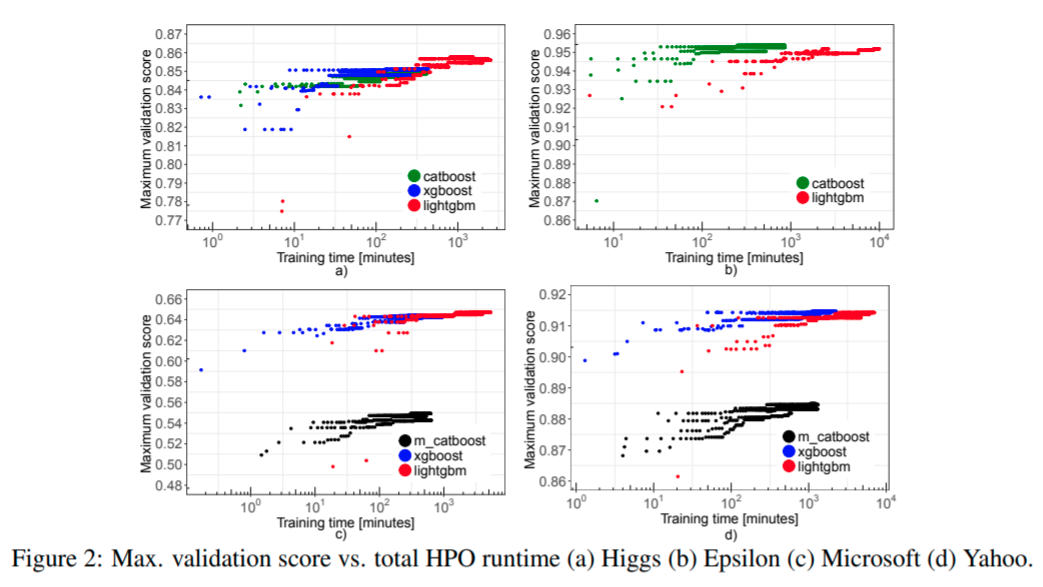

Некоторые выводы:

* XGBoost и Catboost обучаются примерно одинаковое время, а LightGBM немного медленнее.

* Есть задачи (например, в бинарной классификации на датасете Higgs), где LightGBM превосходит и Catboost, и XGBoost, но не везде (см. данные Epsilon и Yahoo). Тем не менее, обычно он близок к оптимальному

* При большом количестве признаков Catboost сходится значительно быстрее, в то время как XGBoost может не успеть обучиться (Epsilon)

* Catboost обеспечивает эффективную обработку категориальных признаков без дополнительного кода. В случае LightGBM/XGBoost нам придется делать это вручную.

* При минимальной или нулевой настройке гиперпараметров Catboost часто работает лучше всех

* Для всех моделей этап нахождения оптимальных гиперпараметров составляет более 99% времени обучения
  * При выборе того или иного метода необходимо учитывать время подбора гиперпараметров модели, а не только скорость обучения конечной модели.

## Общая идея ансамбля моделей

Нам предстоит найти функцию в виде $$f(x) = \alpha_0 + \sum_{T_k \in \mathbf{T} } \alpha_k T_k(x),$$ где $\mathbf{T}$ - набор базисных функций, обычно деревьев. Для градиентного бустинга и случайных лесов $|\mathbf{T}|$ обычно очень велико (тысячи деревьев).

Friedman and Popescu (2003) предлагают гибридный подход, который разбивает этот процесс на два этапа:
- Конечное множество $\mathbf{T}_L = \{T_1(x), T_2(x), . . . , T_M(x)\}$ базисных функций изучается на основе обучающих данных;
- Набор функций $f_{\lambda}(x)$ строится путем подбора траектории Лассо-регуляризации: $$ \hat{\alpha}(\lambda) = arg \min_{\alpha} \sum_{i=1}^N L\left[y_i, \alpha_0 + \sum_{T_k \in \mathbf{T} } \alpha_k T_k(x_i) \right] + \lambda \sum_{k=1}^M |\alpha_k|$$

В простейшем случае эта модель может рассматриваться как способ постобработки бустинга или случайного леса: берется коллекция деревьев, созданных алгоритмами градиентного бустинга или случайного леса. Подгоняя Лассо к этим деревьям, мы, как правило, используем гораздо меньший набор данных, что позволяет сэкономить на вычислениях и размере данных для будущих предсказаний.

Давайте попробуем разобраться, как сделать эффективную реализацию этого.

## Зачем использовать Лассо?

Представим ситуацию, когда у нас есть огромное количество регрессоров, скажем $10^3$, и далее представим два варианта:
1. только $10$ из $10^3$ регрессоров являются значимыми
2. почти все регрессоры из $10^3$ значимы.

В первом случае регуляризация $L_1$ победит $L_2$, так как даст разреженное решение и найдет эти $10$ значимых регрессоров (по крайней мере, для некоторой $\lambda$). Во втором случае у нас будут проблемы из-за проклятия размерности, поэтому обе модели, скорее всего, не смогут выучить какие-либо значимые взаимосвязи.

Другими словами, использование штрафа $L_1$ приводит к принципу "ставки на разреженность" для задач с входными данными высокой размерности:
> Используйте процедуру, которая хорошо справляется с разреженными задачами, поскольку ни одна процедура не справляется с плотными задачами.

Конечно, для любого конкретного приложения степень разреженности/плотности зависит от неизвестной истинной целевой функции и выбранного набора $\mathbf{T}$.

## Ансамбль обучения с выборкой по важности (Importance sampled learning ensemble, ISLE)

Общий алгоритм построения ансамбля:

1. Начинаем с постоянного предсказания $$f_0(x) = arg\min_c \sum_{i=1}^N L(y_i, c)$$
2. Для $m=1, ..., M$:
  - Получаем **случайную выборку** для тренировочных наблюдений без замены, $S_m(\eta)$, где $\eta \in (0, 1]$ - доля объектов
  - Находим **следующую модель** $$\gamma_m = arg\min_\gamma \sum_{i \in S_m(\eta)} L\left[y_i, f_{m-1}(x_i) + b(x_i, \gamma)\right]$$
  - Объединяем их в **совокупность** $$f_{m}(x) = f_{m-1}(x) + \nu b(x, \gamma_m)$$
3. Получаем набор $\mathbf{T}_{ISLE} = \{b(x, \gamma_1), b(x, \gamma_2), . . . , b(x, \gamma_M)\}$.

Здесь $b(x; \gamma)$ - некоторые базисные функции. Например, если базисные функции являются деревьями, то $\gamma$ представляет переменные разбиения, точки разбиения и значения в терминальных узлах.

Параметр $\nu \ в [0, 1]$ привносит в процесс рандомизации; чем больше $\nu$, тем больше процедура избегает $b(x; \gamma)$, подобных найденным ранее.

Ряд знакомых нам подходов являются частными случаями такого алгоритма:
- **Баггинг** имеет $\eta = 1$, но осуществляет выборку с заменой, и имеет $\nu = 0$.
- **Случайный лес** похожа на него, но в нём рандомизация вносится выбором переменной разбиения.
- **Градиентный бустинг** + shrinkage использует $\eta = 1$ и некоторые $\nu$.
- **Стохастический градиентный бустинг** (Friedman, 1999) точно следует рецепту при некоторых $\eta$ и $\nu$.

См. также:
Оригинальная статья: https://statweb.stanford.edu/~jhf/ftp/isle.pdf

Реализация поверх Scikit-learn: https://github.com/yq911122/isle

# Библиотека H2O и данные

Согласно документации https://docs.h2o.ai/:
> H2O is an open source, in-memory, distributed, fast, and scalable machine learning and predictive analytics platform that allows you to build machine learning models on big data and provides easy productionalization of those models in an enterprise environment.

In [ ]:
!pip install h2o
import h2o
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 16 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,"28 days, 3 hours and 28 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_yvqgo3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.782 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Датасет: https://archive.ics.uci.edu/ml/datasets/HIGGS

In [ ]:
# higgs = h2o.import_file("https://h2o-public-test-data.s3.amazonaws.com/smalldata/testng/higgs_train_5k.csv")

train = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_train_10k.csv")
test = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_test_5k.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Identify predictors and response
predictors = train.columns
response = "response"
predictors.remove(response)

# For binary classification, response should be a factor
# train[response] = train[response].asfactor()

# # split into train and validation sets
# train, valid = predictors.split_frame(ratios = [.8])

# Случайный лес

Описание: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

In [ ]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

# Train & Cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=5,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=123)

my_rf.train(x=predictors,
            y=response,
            training_frame=train,
            validation_frame=test)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1685110804099_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          944228                 20           20           20            1350          1568          1497.76

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.20404596061725616
RMSE: 0.45171446801852183
LogLoss: 0.6096510883922617
Mean Per-Class Error: 0.3668600397985387
AUC: 0.7459883454304433
AUCPR: 0.7569180566327297
Gini: 0.4919766908608867

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36849888849096063
       0     1     Error    Rate
-----  ----  ----  -------  ----------------
0      1762  2943  0.6255   (2943.0/4705.0)
1      573   4722  0.1082   (573.0/5295.0)
Total  2335  7665  0.3516   (3516.0/10000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368499     0.728704  283
max f2                       0.200047     0.852507  353
max f0point5                 0.535481     0.705234  200
max accuracy                 0.512653     0.6844    211
max precision                0.952963     0.927711  11
max recall                   0            1         399
max specificity              0.999898     0.99915   0
max absolute_mcc             0.535481     0.367084  200
max min_per_class_accuracy   0.526203     0.679887  205
max mean_per_class_accuracy  0.535481     0.683801  200
max tns                      0.999898     4701      0
max fns                      0.999898     5272      0
max fps                      0            4705      399
max tps                      0            5295      399
max tnr                      0.999898     0.99915   0
max fnr                      0.999898     0.995656  0
max fpr                      0            1         399
max tpr                      0            1         399

Gains/Lift Table: Avg response rate: 52.95 %, avg score: 52.87 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.947224           1.7186    1.7186             0.91             0.980428  0.91                        0.980428            0.017186        0.017186                   71.8602   71.8602            0.0152732
2        0.02                        0.926872           1.62417   1.67139            0.86             0.937139  0.885                       0.958783            0.0162417       0.0334278                  62.4174   67.1388            0.0285393
3        0.0308                      0.9                1.69622   1.6801             0.898148         0.912859  0.88961                     0.94268             0.0183192       0.0517469                  69.6219   68.0095            0.0445206
4        0.04                        0.882911           1.60118   1.66195            0.847826         0.891709  0.88                        0.930957            0.0147309       0.0664778                  60.1182   66.1945            0.0562759
5        0.05                        0.868757           1.64306   1.65817            0.87             0.876956  0.878                       0.9201

In [ ]:
# Eval performance:
perf_rf = my_rf.model_performance()

# Generate predictions on a validation set (if necessary):
pred_rf = my_rf.predict(test)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_rf

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.20404596061725616
RMSE: 0.45171446801852183
LogLoss: 0.6096510883922617
Mean Per-Class Error: 0.3668600397985387
AUC: 0.7459883454304433
AUCPR: 0.7569180566327297
Gini: 0.4919766908608867

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36849888849096063
       0     1     Error    Rate
-----  ----  ----  -------  ----------------
0      1762  2943  0.6255   (2943.0/4705.0)
1      573   4722  0.1082   (573.0/5295.0)
Total  2335  7665  0.3516   (3516.0/10000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368499     0.728704  283
max f2                       0.200047     0.852507  353
max f0point5                 0.535481     0.705234  200
max accuracy                 0.512653     0.6844    211
max precision                0.952963     0.927711  11
max recall                   0            1         399
max specificity              0.999898     0.99915   0
max absolute_mcc             0.535481     0.367084  200
max min_per_class_accuracy   0.526203     0.679887  205
max mean_per_class_accuracy  0.535481     0.683801  200
max tns                      0.999898     4701      0
max fns                      0.999898     5272      0
max fps                      0            4705      399
max tps                      0            5295      399
max tnr                      0.999898     0.99915   0
max fnr                      0.999898     0.995656  0
max fpr                      0            1         399
max tpr                      0            1         399

Gains/Lift Table: Avg response rate: 52.95 %, avg score: 52.87 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.947224           1.7186    1.7186             0.91             0.980428  0.91                        0.980428            0.017186        0.017186                   71.8602   71.8602            0.0152732
2        0.02                        0.926872           1.62417   1.67139            0.86             0.937139  0.885                       0.958783            0.0162417       0.0334278                  62.4174   67.1388            0.0285393
3        0.0308                      0.9                1.69622   1.6801             0.898148         0.912859  0.88961                     0.94268             0.0183192       0.0517469                  69.6219   68.0095            0.0445206
4        0.04                        0.882911           1.60118   1.66195            0.847826         0.891709  0.88                        0.930957            0.0147309       0.0664778                  60.1182   66.1945            0.0562759
5        0.05                        0.868757           1.64306   1.65817            0.87             0.876956  0.878                       0.920157            0.0164306       0.0829084                  64.3059   65.8168            0.0699435
6        0.1005                      0.809524           1.63427   1.64616            0.865347         0.837105  0.871642                    0.878424            0.0825307       0.165439                   63.4271   64.616             0.138021
7        0.1513                      0.761905           1.52796   1.60647            0.809055         0.784256  0.850628                    0.846807            0.0776204       0.243059                   52.7961   60.6474            0.195025
8        0.2              

# Градиентный бустинг

Описание: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

In [ ]:
from h2o.estimators import H2OGradientBoostingEstimator

# Build and train the model:
my_gbm = H2OGradientBoostingEstimator(nfolds=5,
                                      seed=123,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions = True)

my_gbm.train(x=predictors,
            y=response,
            training_frame=train,
            validation_frame=test)

# Eval performance:
perf_gbm = my_gbm.model_performance()

# Generate predictions on a test set (if necessary):
pred_gbm = my_gbm.predict(test)

# Extract feature interactions:
feature_interactions = my_gbm.feature_interaction()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


# Характеристики и интерпретируемость модели

Посмотрим на ROC-характеристику:

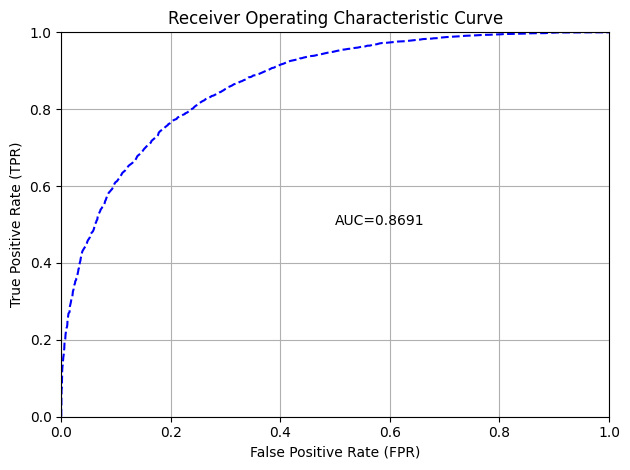

In [ ]:
perf_gbm.plot(type = "roc");

А также на Precision-Recall:

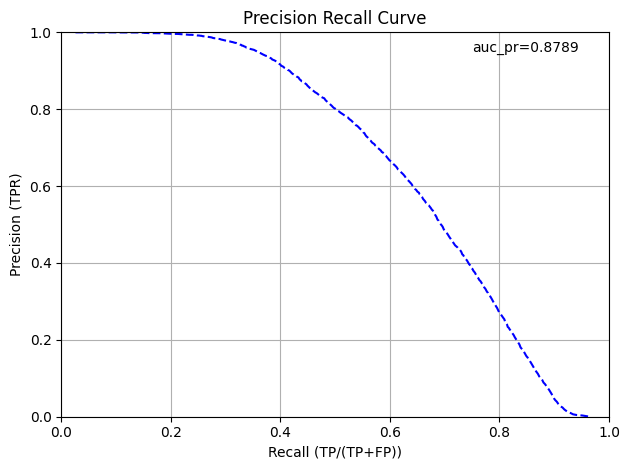

In [ ]:
perf_gbm.plot(type = "pr");

Важность предикторов:

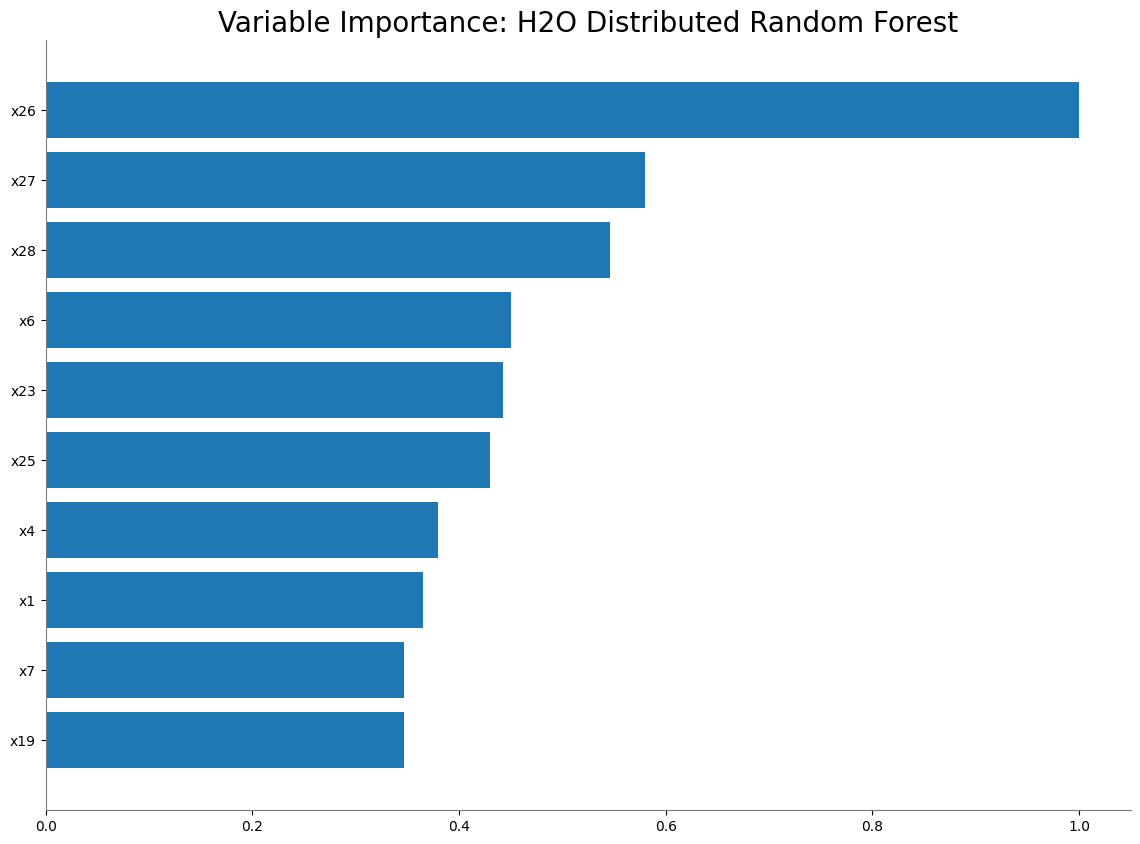

<Figure size 640x480 with 0 Axes>

In [ ]:
my_rf.varimp_plot();

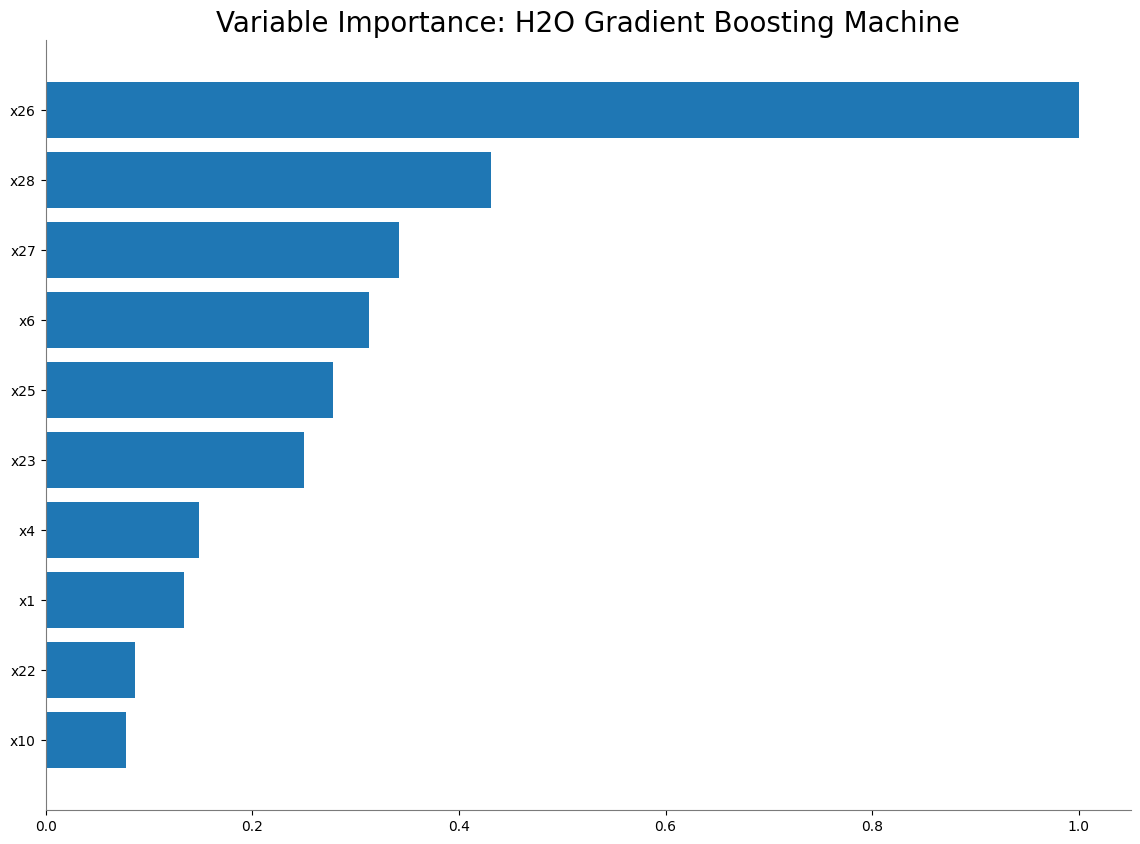

<Figure size 640x480 with 0 Axes>

In [ ]:
my_gbm.varimp_plot();

Можно получить "автоматическую" интерпретацию данных в используемой модели:

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

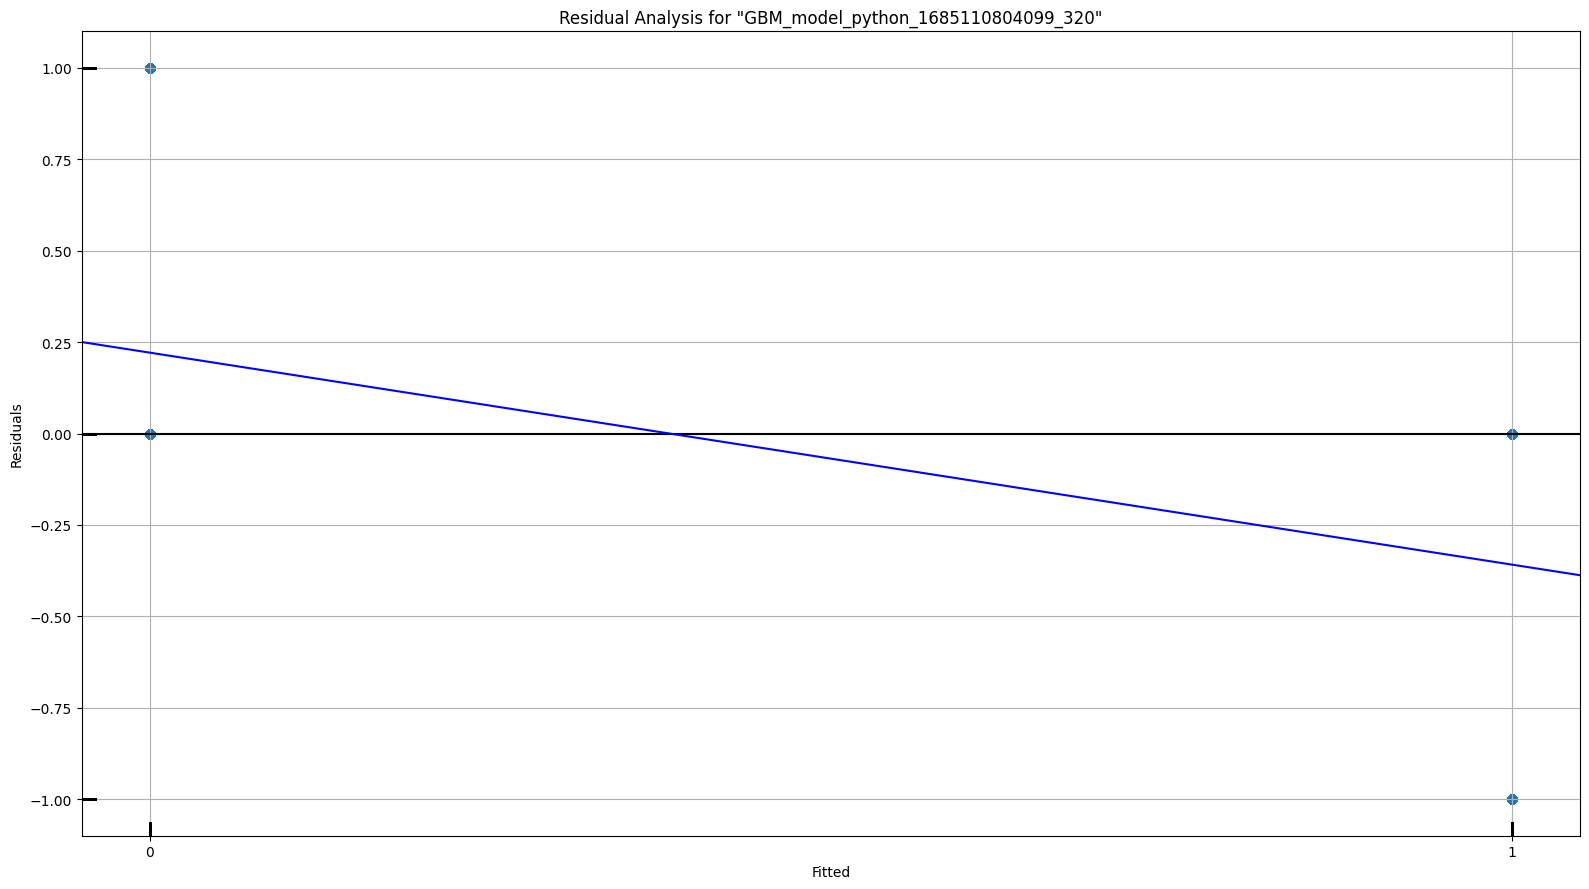

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

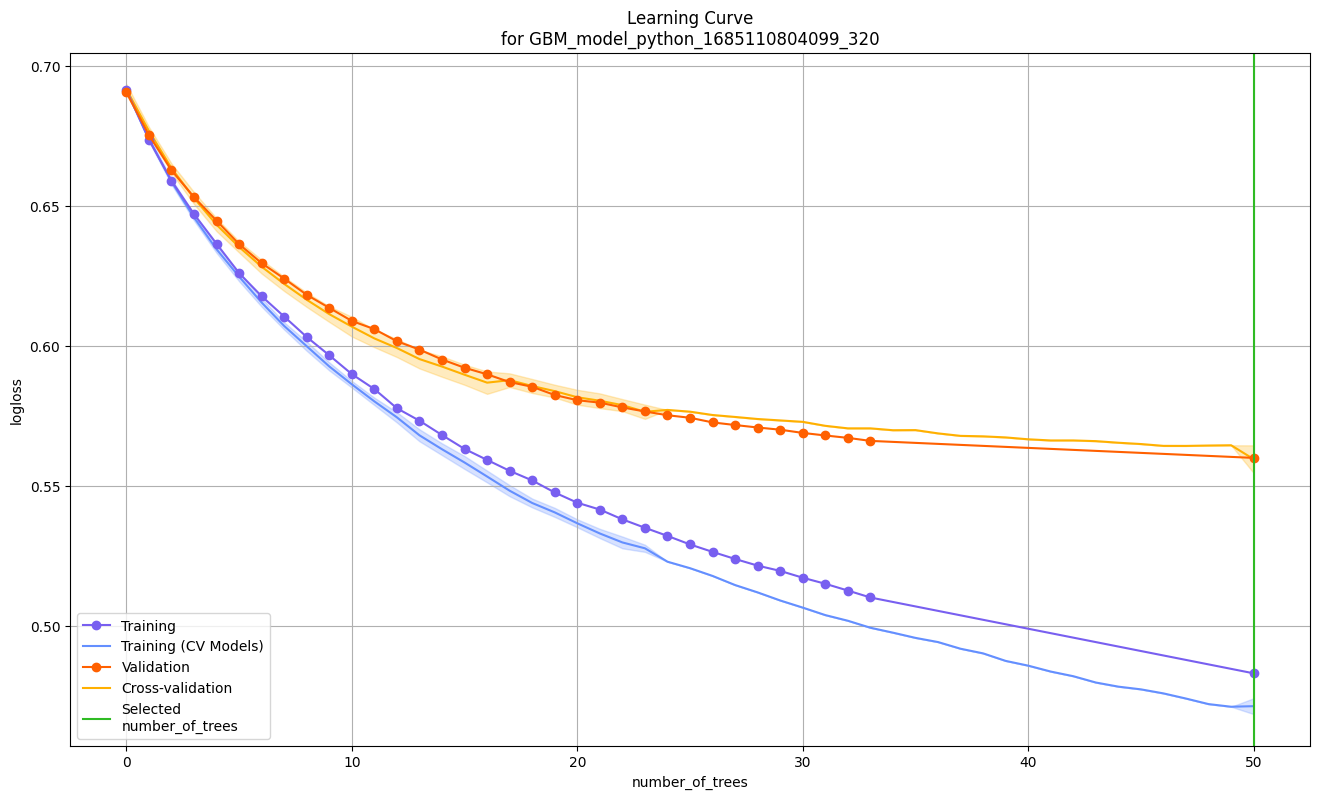

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

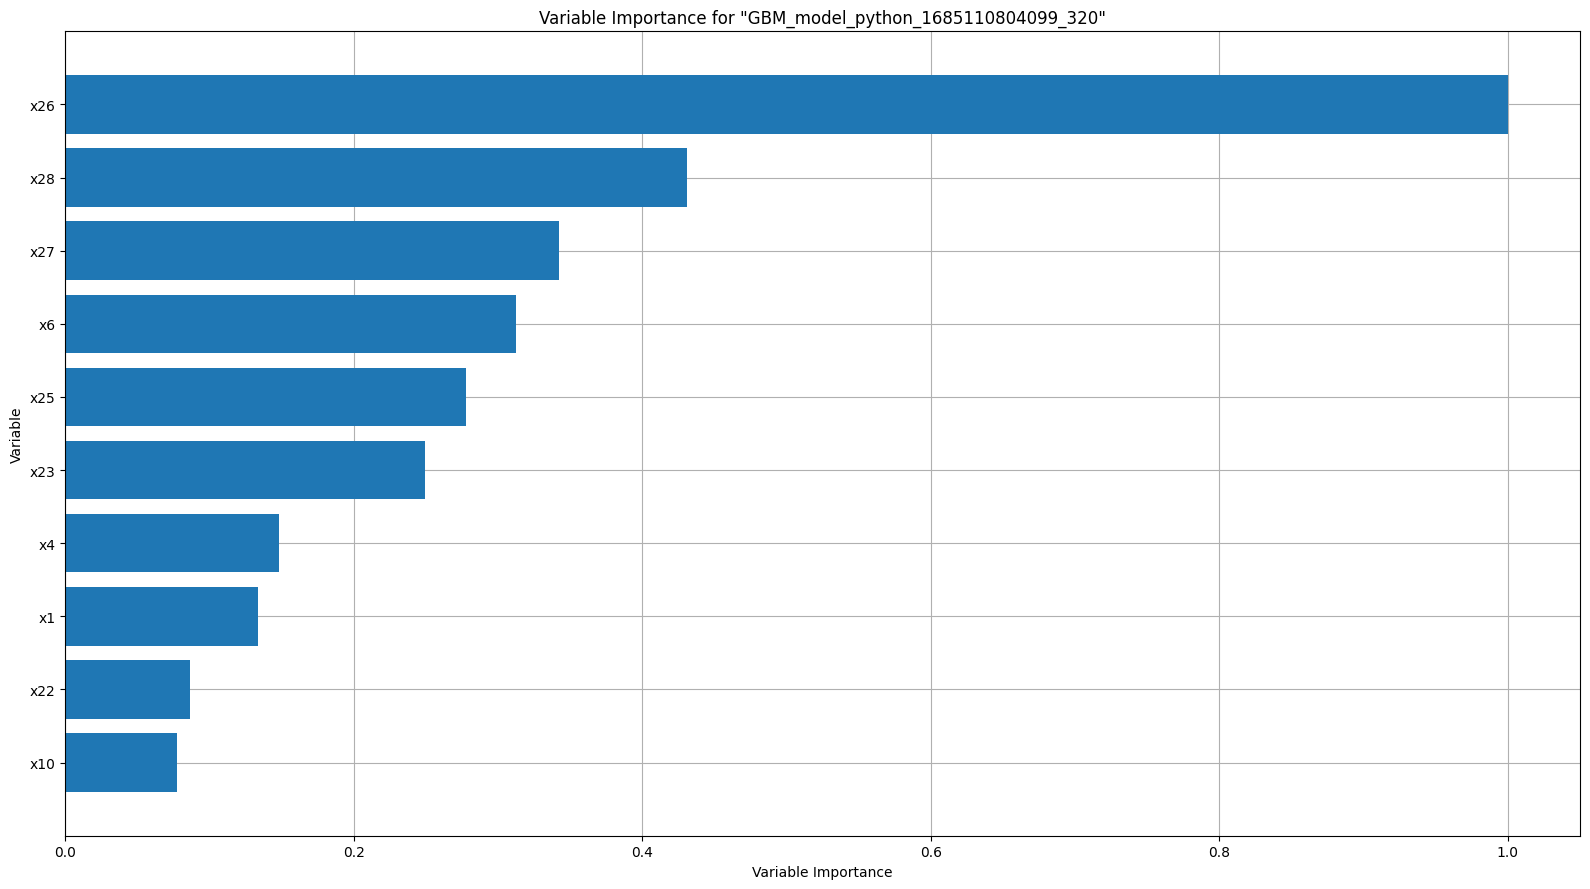

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

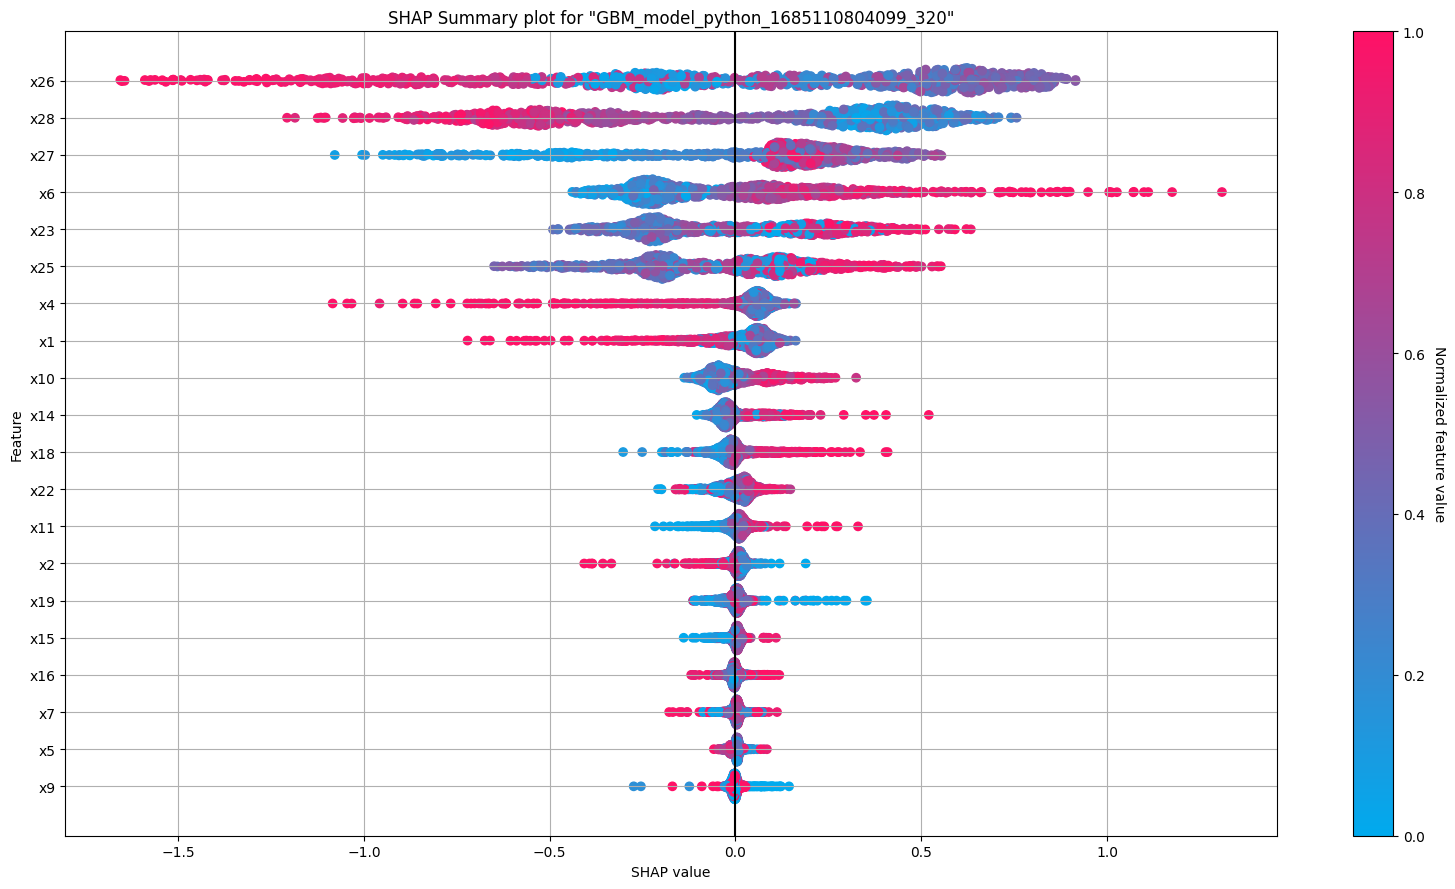

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

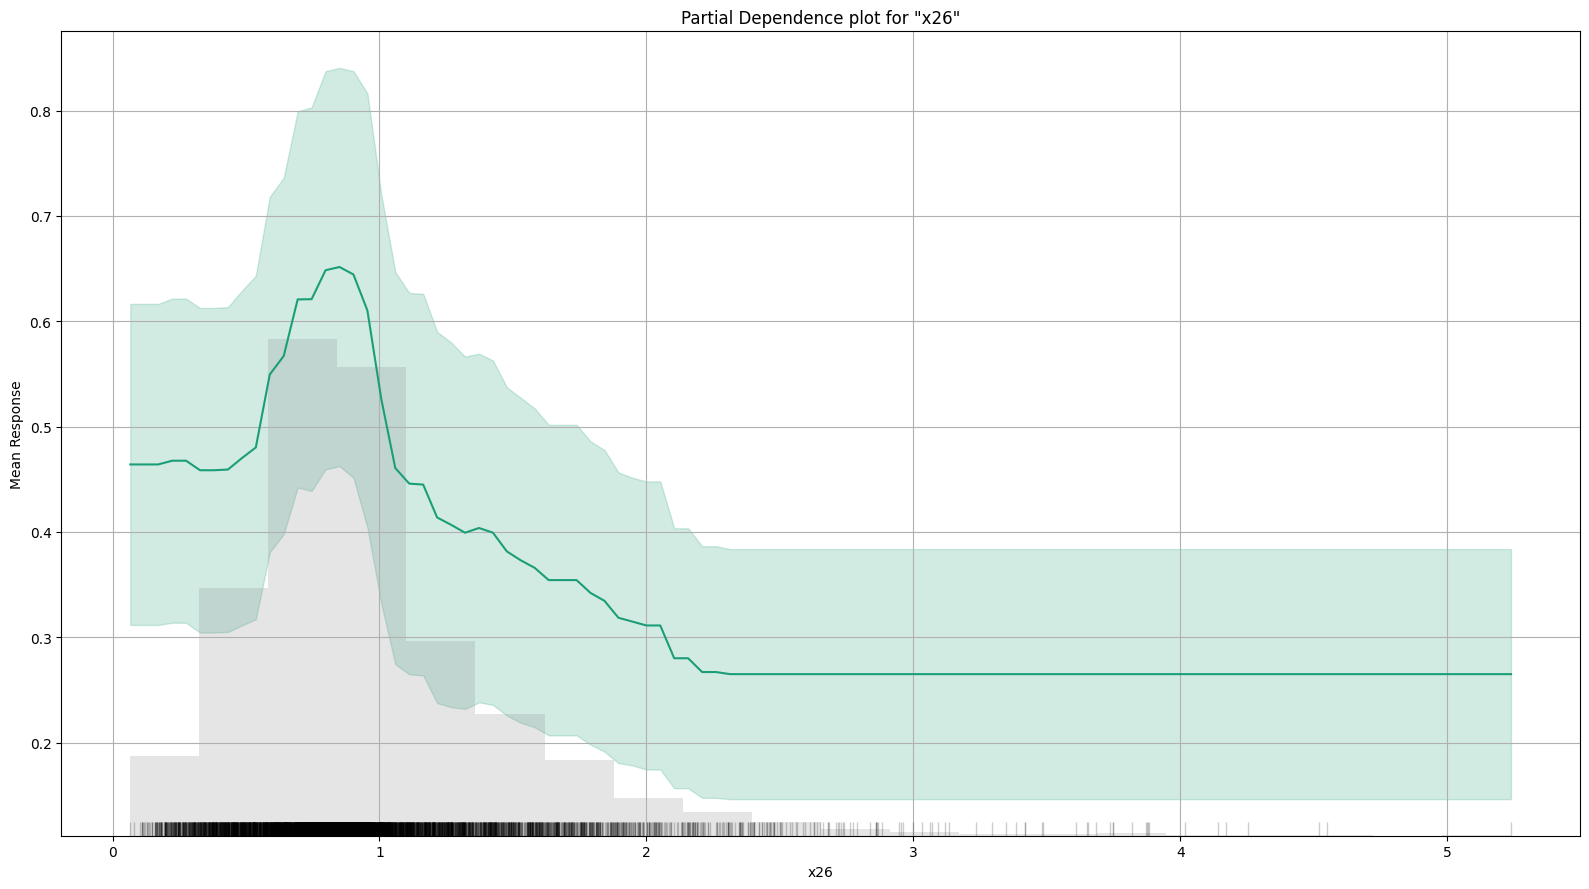

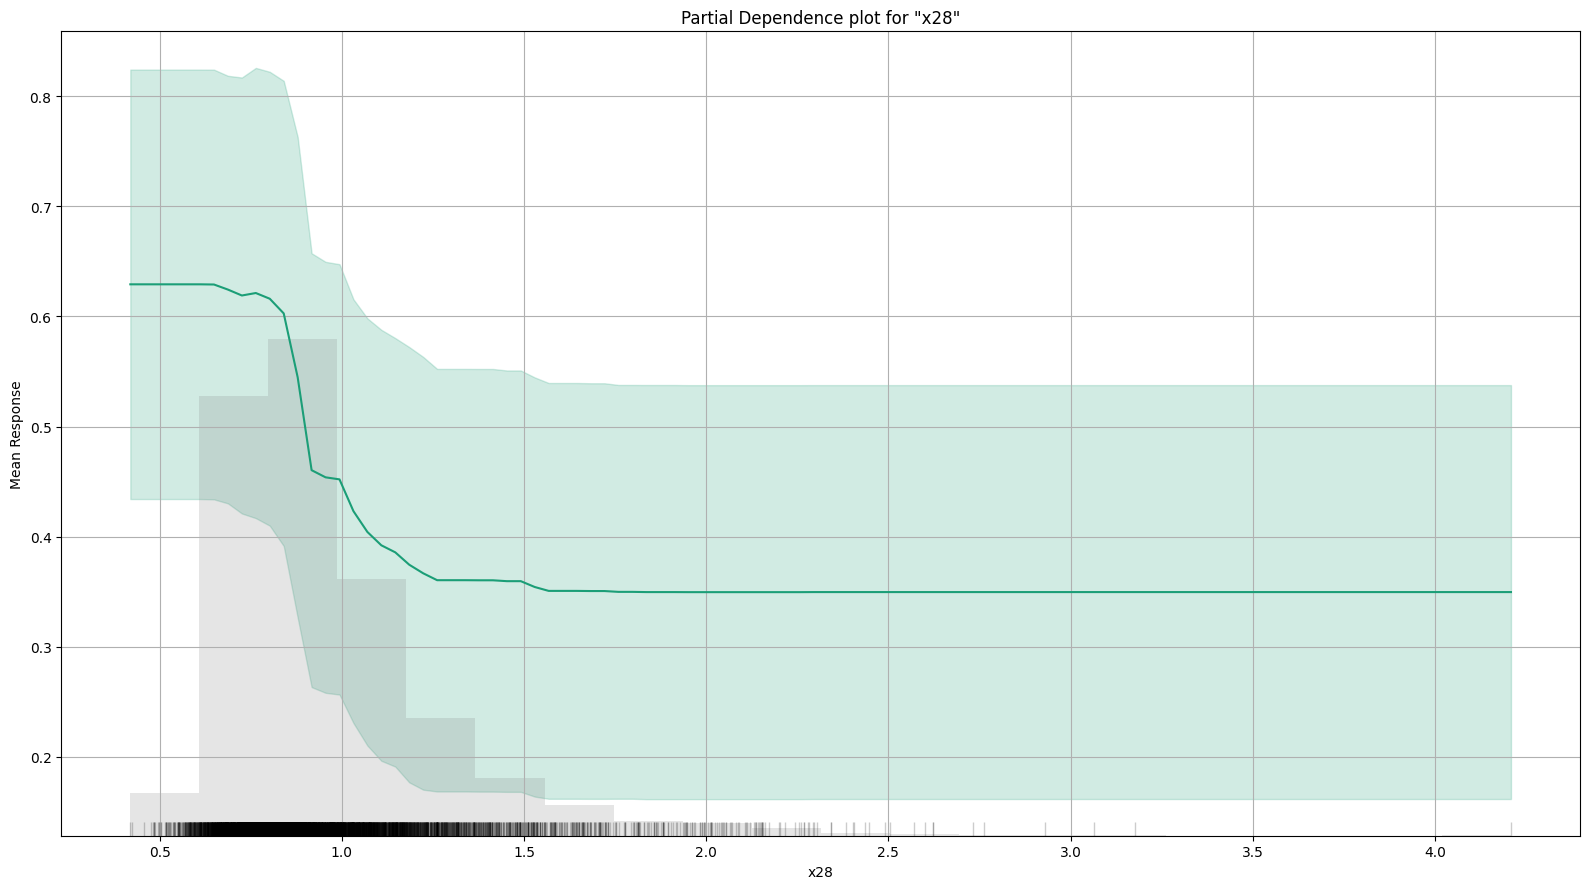

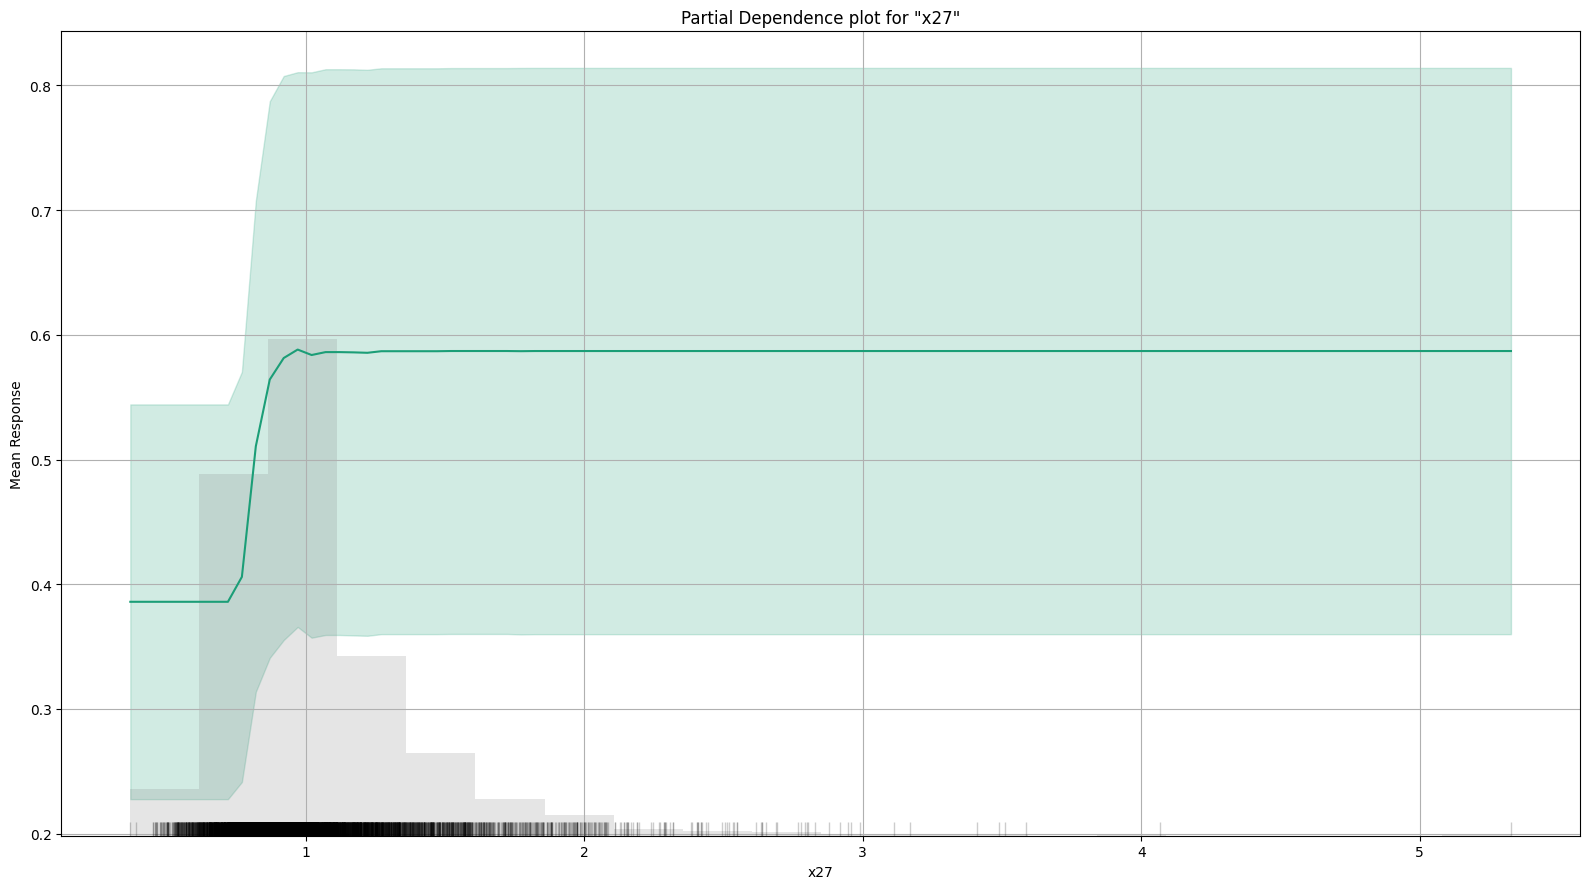

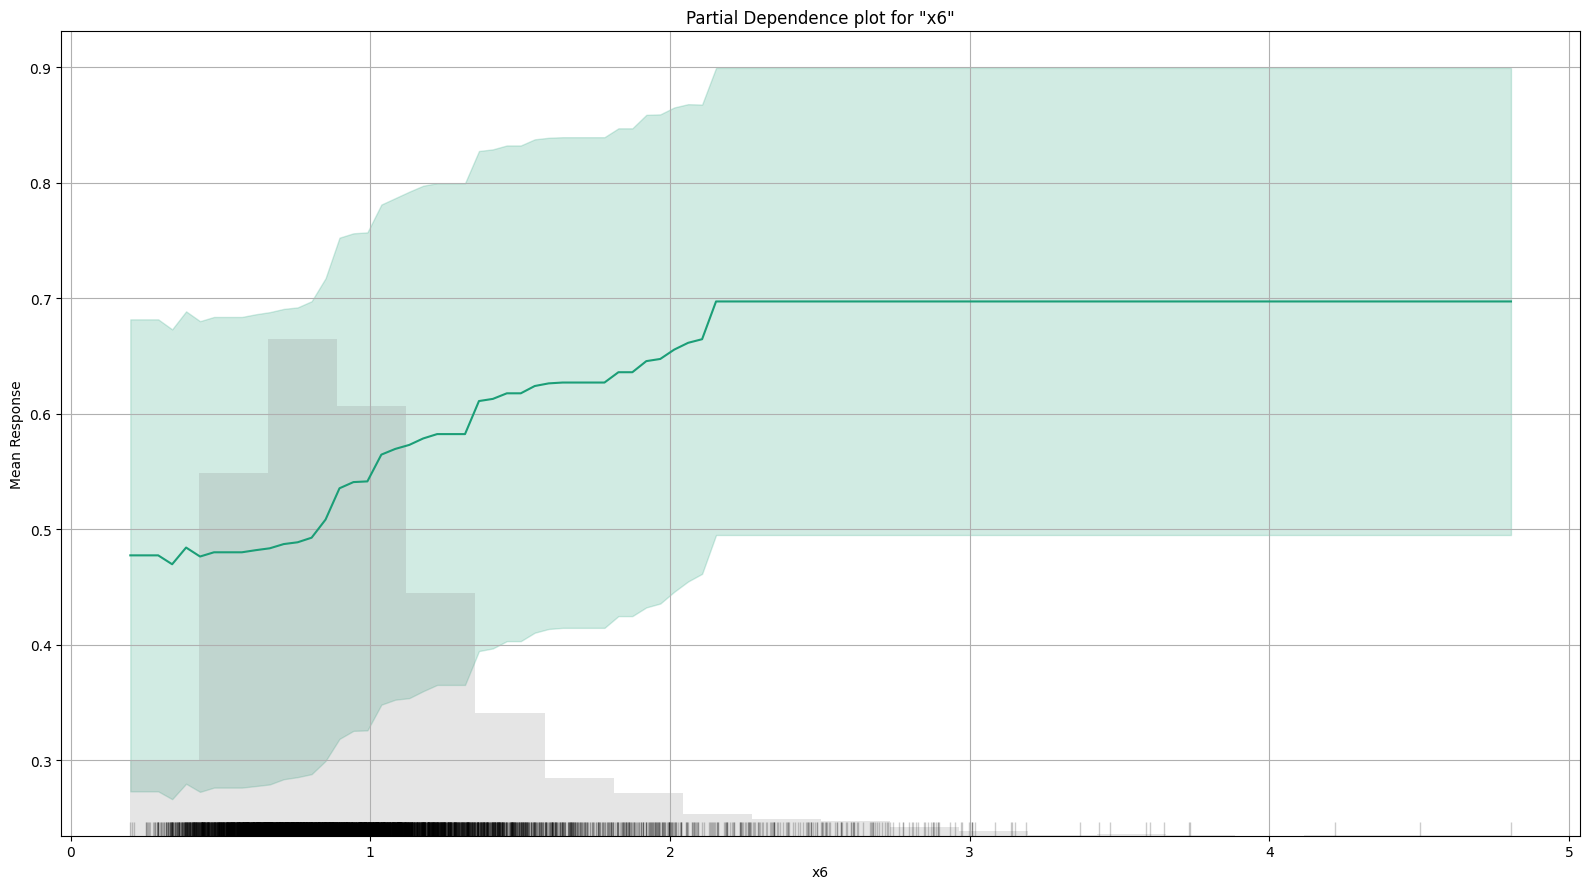

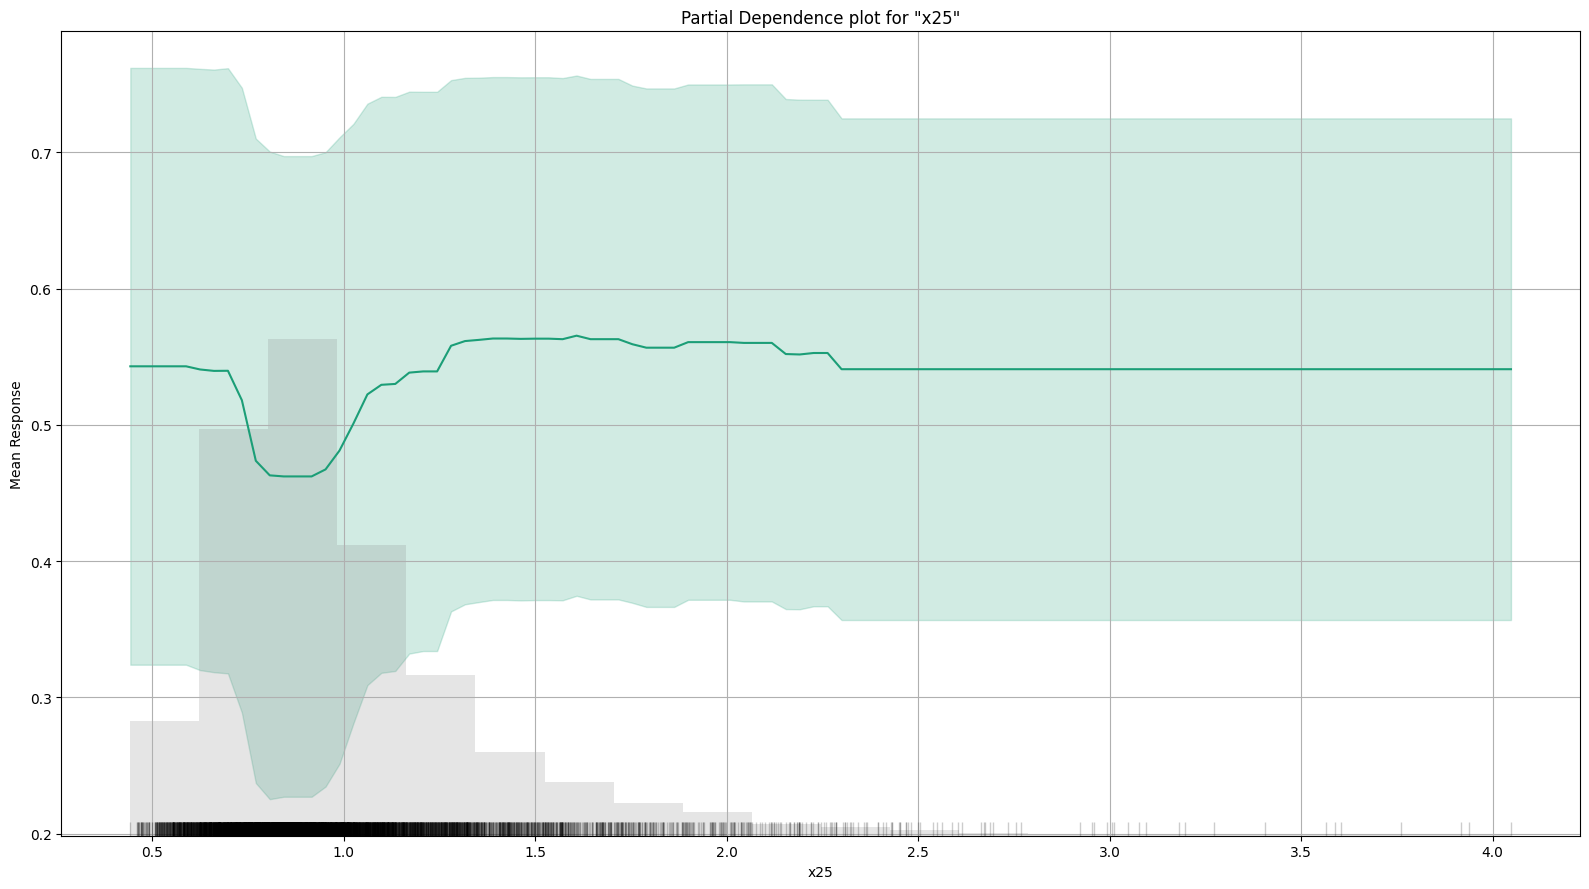

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

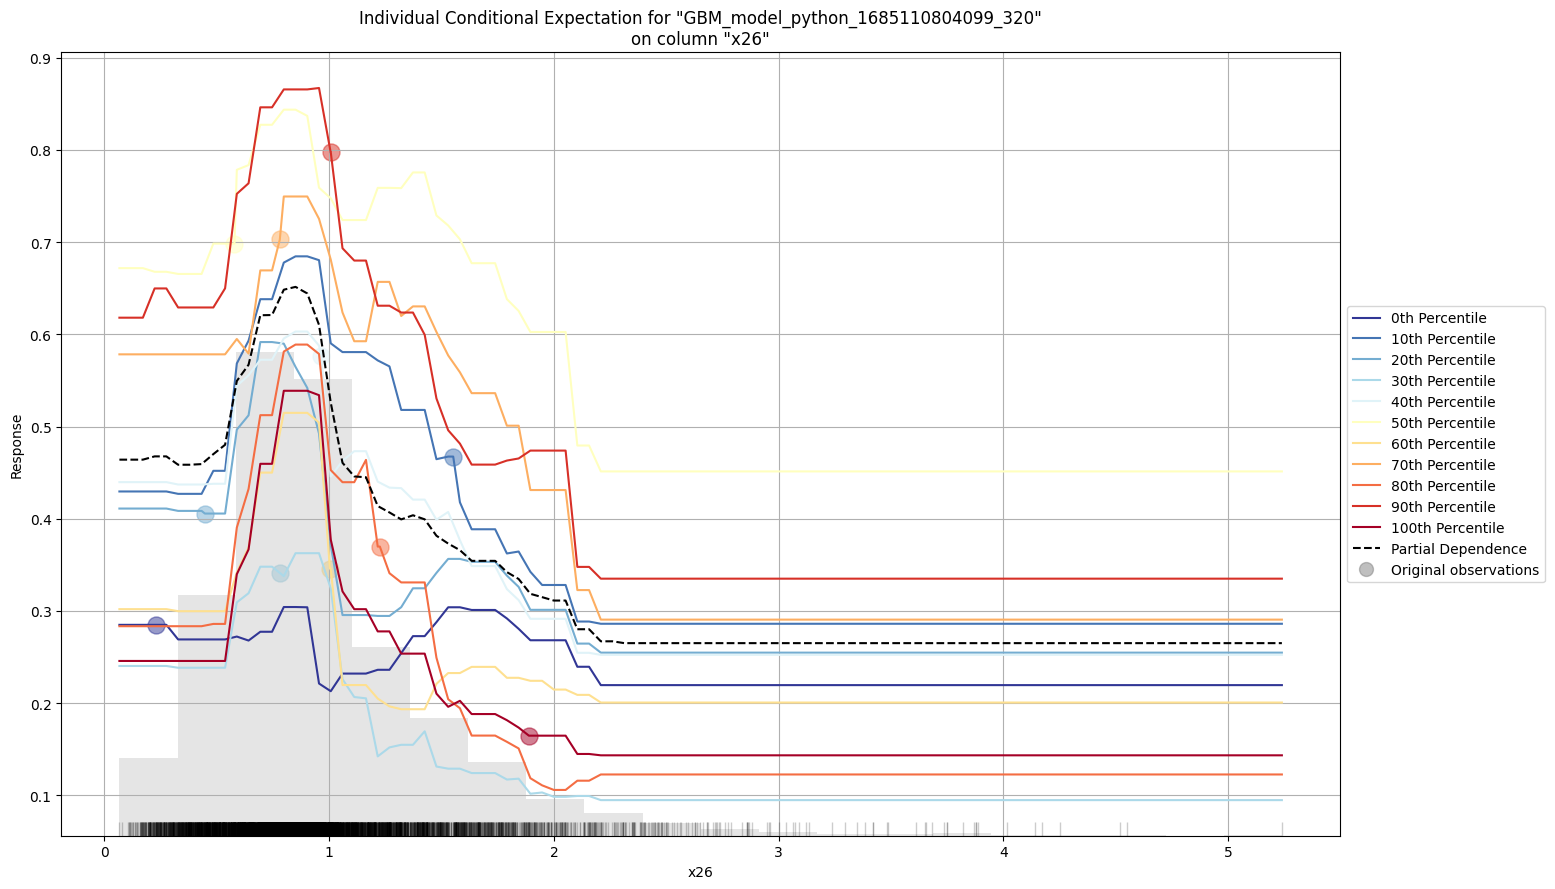

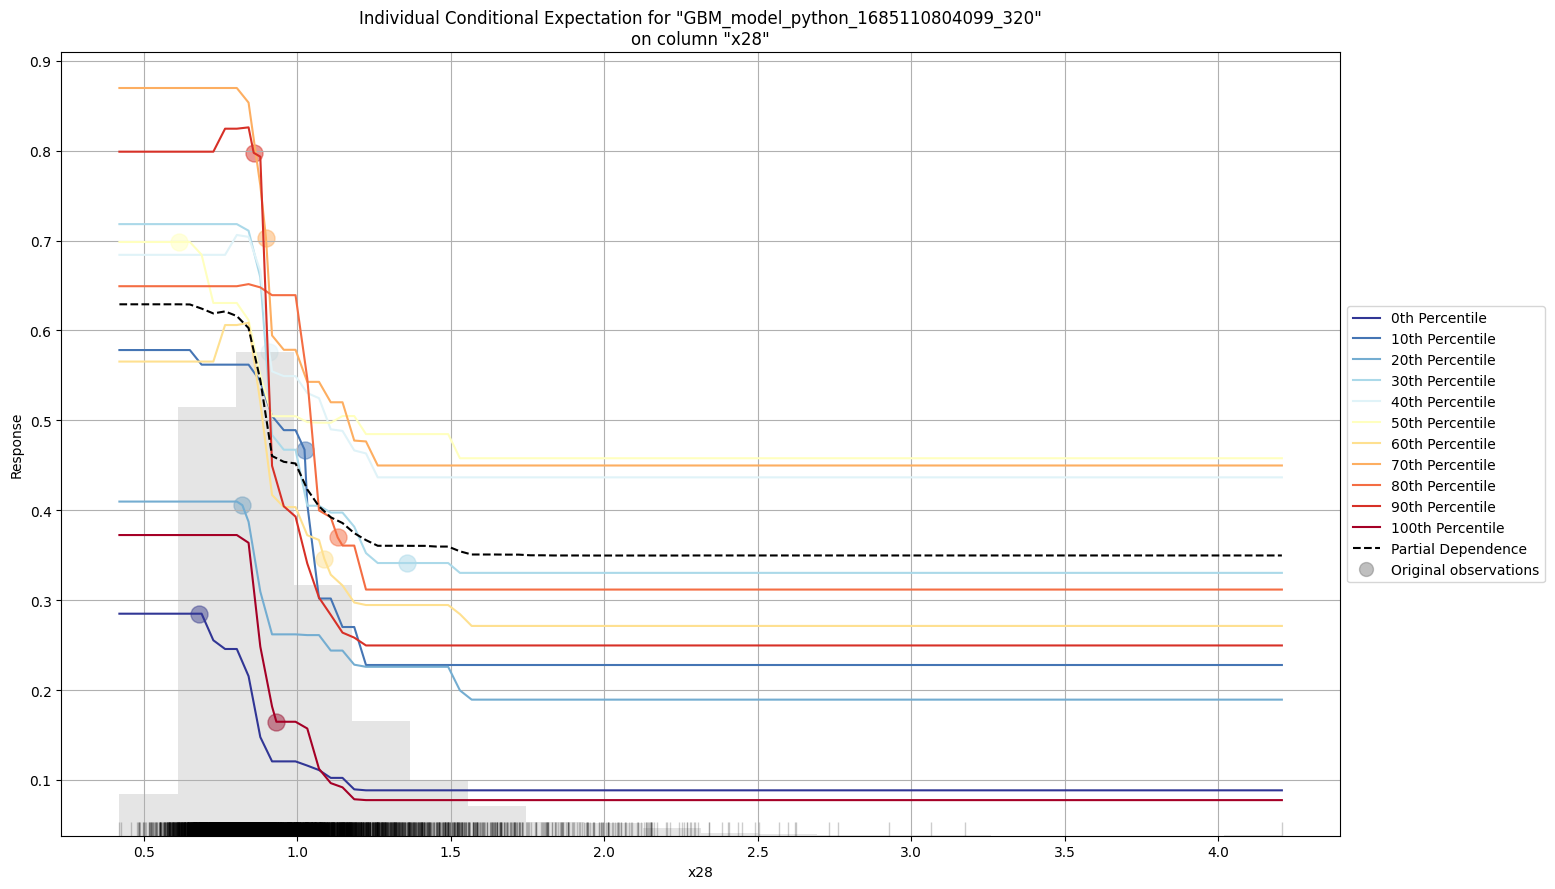

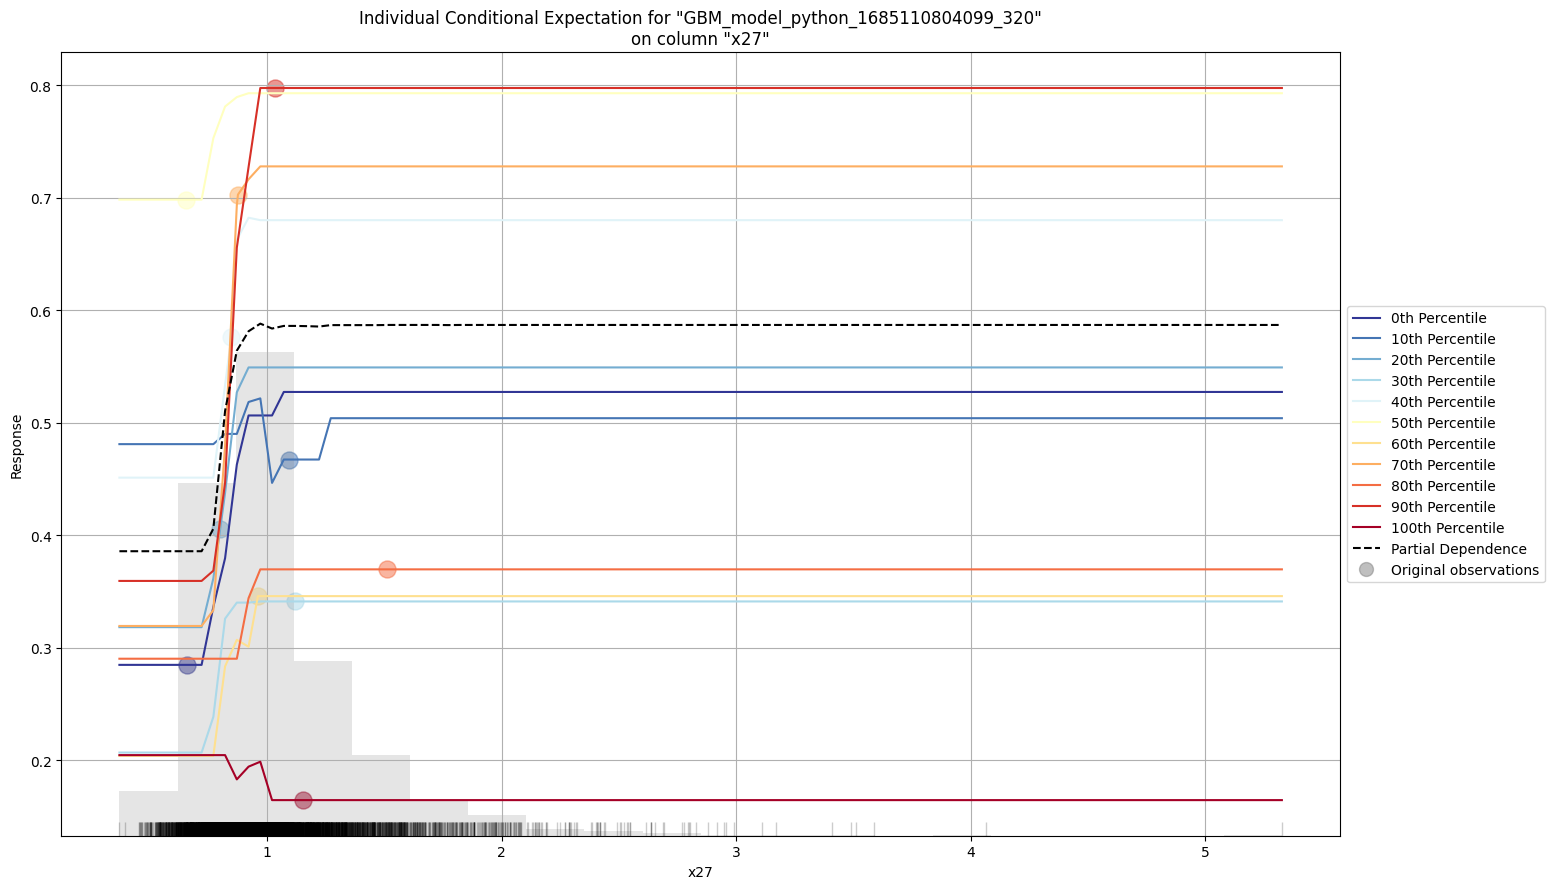

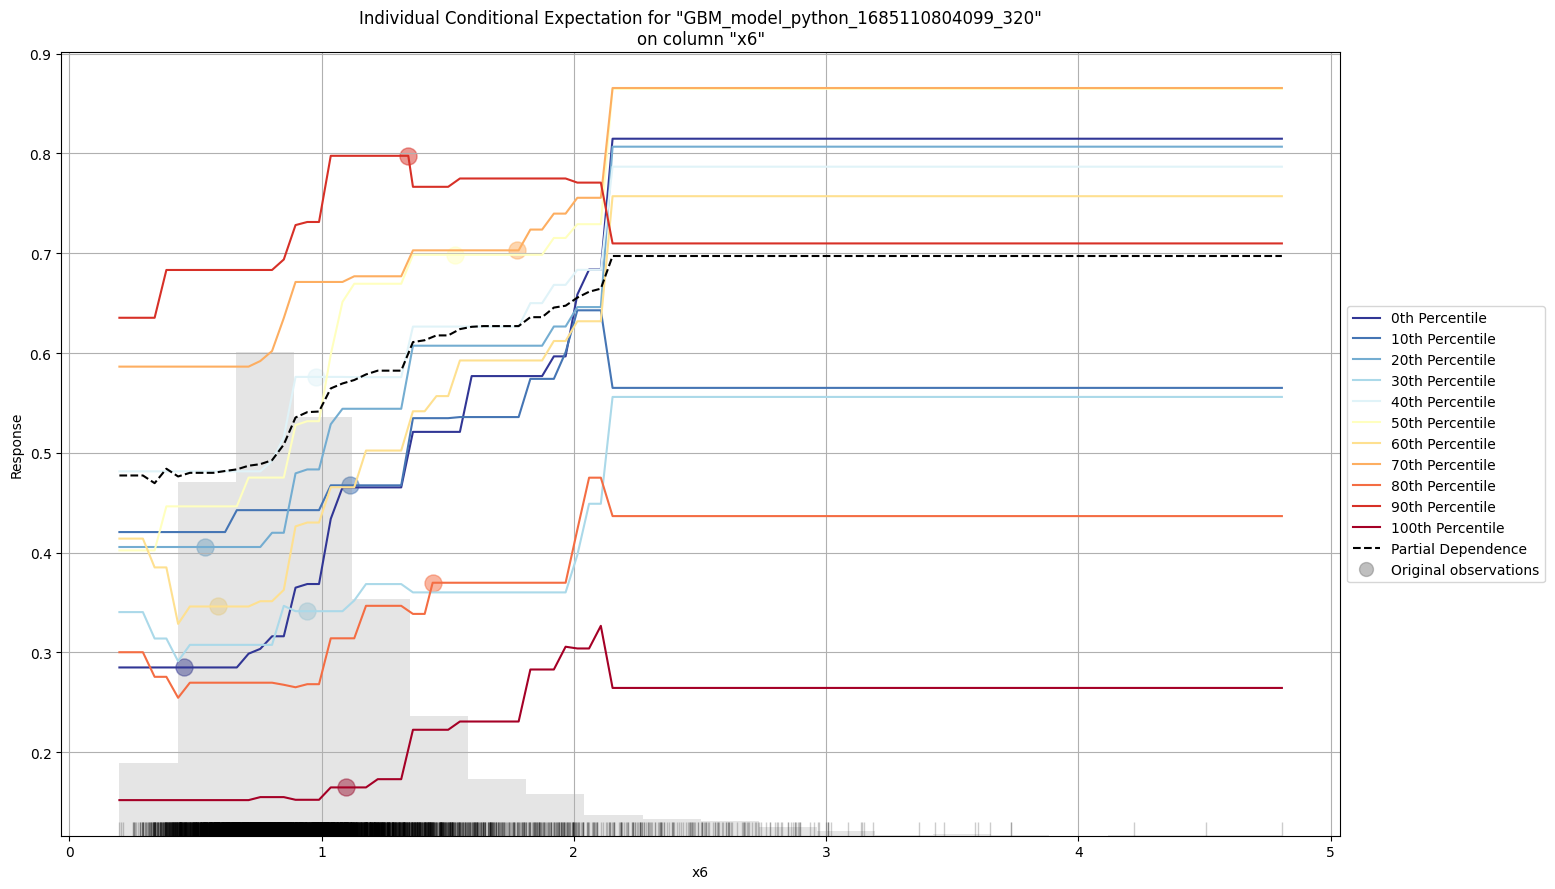

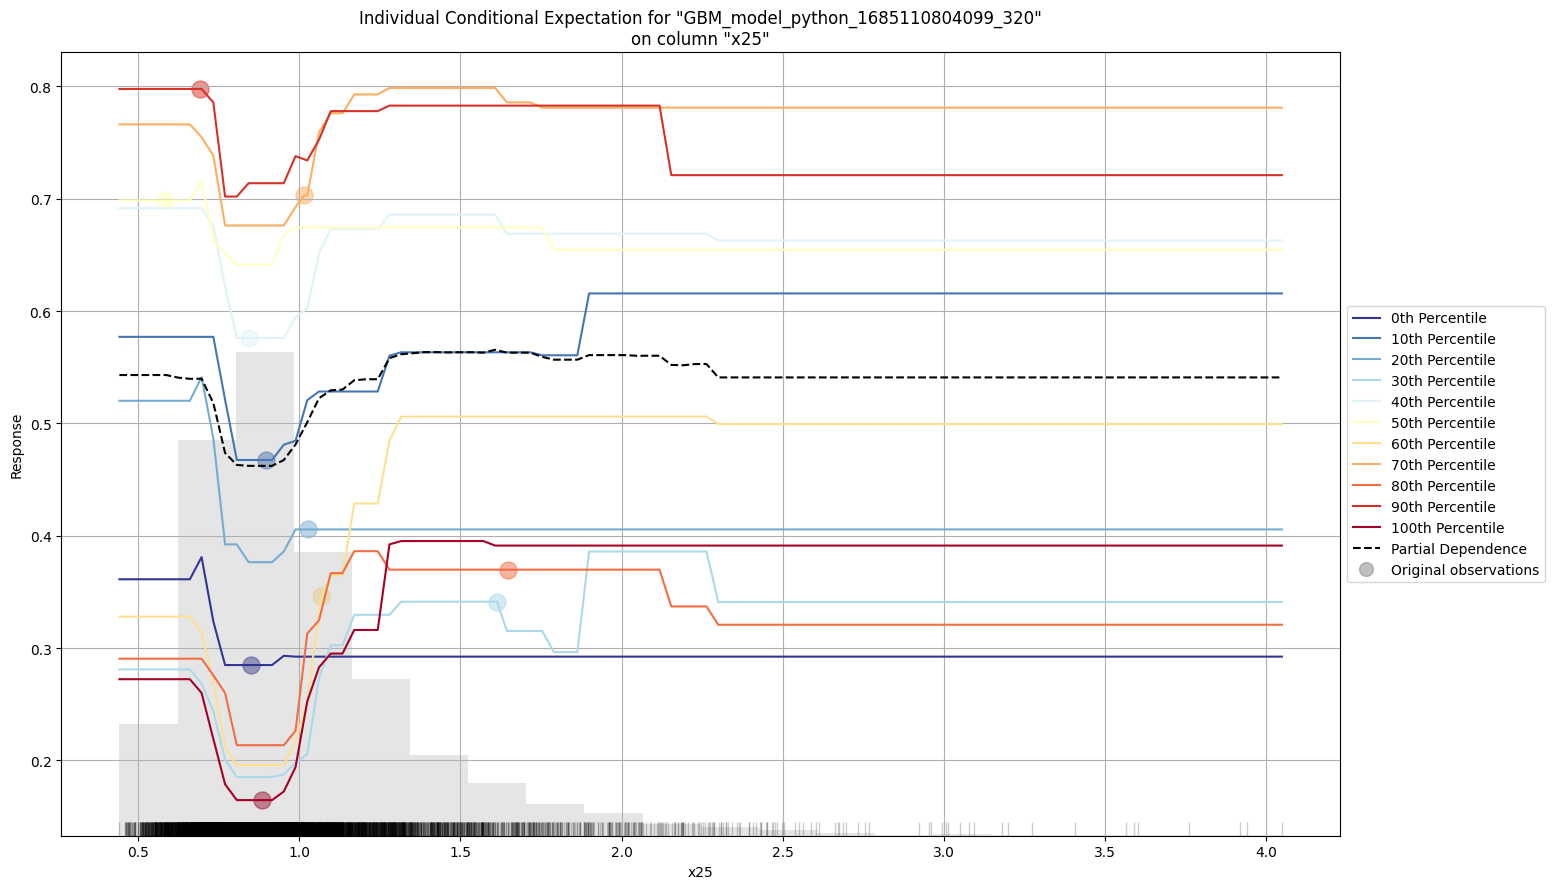

In [ ]:
my_gbm.explain(test);

Gains/Lift Table

См.: https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/GainsLift.md

In [ ]:
my_gbm.gains_lift(test)

group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.01,0.9173895,1.8885741,1.8885741,1.0,0.9312264,1.0,0.9312264,0.0188857,0.0188857,88.8574127,88.8574127,0.0188857
2,0.02,0.9042422,1.8696884,1.8791313,0.99,0.9101145,0.995,0.9206705,0.0186969,0.0375826,86.9688385,87.9131256,0.0373701
3,0.03,0.8950124,1.8696884,1.8759836,0.99,0.8990888,0.9933333,0.9134766,0.0186969,0.0562795,86.9688385,87.5983632,0.0558544
4,0.04,0.8869372,1.8319169,1.8649669,0.97,0.8912849,0.9875,0.9079287,0.0183192,0.0745987,83.1916903,86.4966950,0.0735360
5,0.05,0.8776191,1.8696884,1.8659112,0.99,0.8821771,0.988,0.9027783,0.0186969,0.0932956,86.9688385,86.5911237,0.0920203
6,0.1,0.8365357,1.8092540,1.8375826,0.958,0.8567585,0.973,0.8797684,0.0904627,0.1837583,80.9254013,83.7582625,0.1780197
7,0.15,0.7989677,1.7450425,1.8067359,0.924,0.8179982,0.9566667,0.8591784,0.0872521,0.2710104,74.5042493,80.6735914,0.2571953
8,0.2,0.7630377,1.6657224,1.7714825,0.882,0.7815864,0.938,0.8397804,0.0832861,0.3542965,66.5722380,77.1482531,0.3279416
9,0.3,0.6880353,1.5505194,1.6978281,0.821,0.7249582,0.899,0.8015063,0.1550519,0.5093484,55.0519358,69.7828140,0.4449489
10,0.4,0.6113083,1.3881020,1.6203966,0.735,0.6507989,0.858,0.7638295,0.1388102,0.6481586,38.8101983,62.0396601,0.5274360


# Объединение моделей

Стекинг, также называемый суперобучением или стекированной регрессией, - это класс алгоритмов, который предполагает обучение "метаобучаемого" второго уровня для поиска оптимальной комбинации базовых обучающих элементов. В отличие от bagging и boosting, целью стекирования является объединение сильных, разнообразных наборов обучающих элементов.

При суммировании мы хотим найти функцию не в виде линейной функции

$$f(x) = \alpha_0 + \sum_{T_k \in \mathbf{T} } \alpha_k T_k(x),$$

но в виде нелинейной функции:

$$f(x) = G\left( T_1(x), T_2(x), ..., T_M(x)\right)$$

Алгоритм стекинга выглядит следующим образом:
1. Создаём ансамбль
  - Задаём набор из $L$ базовых алгоритмов (с определенным набором параметров модели).
  - Задаём "metalearning" алгоритм.

2. Обучаем ансамбль
  - Обучаем каждый из $L$ базовых алгоритмов на обучающей выборке.
  - Выполняем $k$-фолдовую кросс-валидацию для каждого из этих обучающих алгоритмов и соберите кросс-валидированные предсказанные значения от каждого из $L$ алгоритмов.
  - $N$ кросс-валидированных прогнозируемых значений от каждого из $L$ алгоритмов могут быть объединены в новую матрицу $N \times L$. Эта матрица вместе с исходным вектором ответов называется данными "первого уровня". ($N$ = количество строк в обучающей выборке).
  - Обучаем алгоритм metalearning на данных первого уровня. Ансамблевая модель" состоит из $L$ базовых моделей обучения и модели metalearning, которая затем может быть использована для создания прогнозов на тестовом наборе.

3. Прогнозирование на новых данных.
  - Чтобы создать ансамблевые прогнозы, сначала создаём прогнозы на основе базовых обучающих моделей.
  - Отправляем эти прогнозы в модель metalearner для создания ансамблевого прогноза.

Описание: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/stacked-ensembles.html

In [ ]:
my_rf.auc(train=True, valid=True, xval=False)

{'train': 0.7459883454304433, 'valid': 0.7674383323077171}

In [ ]:
my_gbm.auc(train=True, valid=True, xval=False)

{'train': 0.8691464989628899, 'valid': 0.7816824128930021}

In [ ]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_rf, my_gbm])
ensemble.train(x=predictors,
              y=response,
              training_frame=train,
              validation_frame=test)

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: my_ensemble_binomial


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  2/2
# GBM base models (used / total)      1/1
# DRF base models (used / total)      1/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    AUTO
Metalearner nfolds                    0
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09232182632528745
RMSE: 0.3038450696083243
LogLoss: 0.33058253410362265
AUC: 0.9706418442598685
AUCPR: 0.9740139479202773
Gini: 0.9412836885197371
Null degrees of freedom: 9999
Residual degrees of freedom: 9997
Null deviance: 13828.113387424315
Residual deviance: 6611.650682072453
AIC: 6617.650682072453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4733094246980352
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4035  670   0.1424   (670.0/4705.0)
1      303   4992  0.0572   (303.0/5295.0)
Total  4338  5662  0.0973   (973.0/10000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473309     0.911198  214
max f2                       0.363971     0.946543  255
max f0point5                 0.618793     0.91729   158
max accuracy                 0.483619     0.9028    210
max precision                0.936573     1         0
max recall                   0.203368     1         329
max specificity              0.936573     1         0
max absolute_mcc             0.473309     0.806077  214
max min_per_class_accuracy   0.527623     0.898831  192
max mean_per_class_accuracy  0.49673      0.901135  205
max tns                      0.936573     4705      0
max fns                      0.936573     5290      0
max fps                      0.0595645    4705      399
max tps                      0.203368     5295      329
max tnr                      0.936573     1         0
max fnr                      0.936573     0.999056  0
max fpr                      0.0595645    1         399
max tpr                      0.203368     1         329

Gains/Lift Table: Avg response rate: 52.95 %, avg score: 53.04 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.92314            1.88857     1.88857            1                0.927237  1                           0.927237            0.0188857       0.0188857                  88.8574   88.8574            0.0188857
2        0.02                        0.917791           1.88857     1.88857            1                0.920222  1                           0.923729            0.0188857       0.0377715                  88.8574   88.8574            0.0377715
3        0.03                        0.913844           1.88857     1.88857            1                0.915783  1                           0.921081            0.0188857       0.0566572                  88.8574   88.8574            0.0566572
4        0.04                        0.909992           1.88857     1.88857            1                0.912015  1                           0.918814            0.0188857       0.075543                   88.8574   88.8574            0.

In [ ]:
perf_stack_test = ensemble.model_performance(test)

In [ ]:
ensemble.auc(train=True, valid=True, xval=False)

{'train': 0.9706418442598685, 'valid': 0.784284582373075}

Использование Grid Search

In [ ]:
from h2o.grid.grid_search import H2OGridSearch

# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator(),
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=predictors,
              y=response,
              training_frame=train,
              validation_frame=test)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,logloss
,1.0,0.1,5.0,1.0,gbm_grid1_model_30,0.5599901
,0.2,0.1,9.0,0.8,gbm_grid1_model_16,0.5601762
,1.0,0.1,5.0,0.8,gbm_grid1_model_12,0.5609107
,0.5,0.1,5.0,0.8,gbm_grid1_model_11,0.5617493
,0.5,0.1,9.0,0.8,gbm_grid1_model_17,0.5617611
,0.5,0.1,9.0,1.0,gbm_grid1_model_35,0.5618912
,0.2,0.1,9.0,1.0,gbm_grid1_model_34,0.5625741
,1.0,0.1,9.0,0.8,gbm_grid1_model_18,0.5632726
,1.0,0.1,9.0,1.0,gbm_grid1_model_36,0.5632854
,0.5,0.1,5.0,1.0,gbm_grid1_model_29,0.5636897


In [ ]:
# Get the grid results, sorted by validation AUC
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
gbm_gridperf1

# Grab the top GBM model, chosen by validation AUC
best_gbm1 = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm1.model_performance(test)

best_gbm_perf1.auc()

0.7818368586379011

**Задание** Попробуйте создать stacking модели случайного леса `my_rf` и лучшей модели (по ROC AUC) среди моделей градиентного бустинга, найденной при помощи GridSearch на наборе данных *Higgs*.